# Introduction

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import cpi
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from iso3166 import countries
from datetime import datetime, timedelta, date

### Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [3]:
df_original = pd.read_csv('mission_launches.csv')

# Preliminary Data Exploration

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [4]:
print(f'There are {df_original.shape[0]} rows and {df_original.shape[1]} columns in the dataset\n')
df_original.head()

There are 4324 rows and 9 columns in the dataset



,Unnamed: 0,Unnamed: 0.1,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [5]:
print(f'There are {len(df_original[df_original.duplicated()])} duplicated columns\n')
df_original.info()

There are 0 duplicated columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4324 entries, 0 to 4323
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      4324 non-null   int64 
 1   Unnamed: 0.1    4324 non-null   int64 
 2   Organisation    4324 non-null   object
 3   Location        4324 non-null   object
 4   Date            4324 non-null   object
 5   Detail          4324 non-null   object
 6   Rocket_Status   4324 non-null   object
 7   Price           964 non-null    object
 8   Mission_Status  4324 non-null   object
dtypes: int64(2), object(7)
memory usage: 304.2+ KB


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [100]:
# Remove first two columns
df = df_original[df_original.columns[2:]]

In [101]:
# Add column for inflation-adjusted price (in dollars of most-recent date)
def convert_date(raw_date):
    try:
        converted_date = datetime.strptime(raw_date, '%a %b %d, %Y %H:%M UTC')
    except ValueError:
        converted_date = datetime.strptime(raw_date, '%a %b %d, %Y')
    return converted_date

def convert_price(raw_price):
    if type(raw_price) is str:
        raw_price = raw_price.replace(',', '')
    converted_price = float(raw_price)
    return converted_price

max_datetime = max([convert_date(d) for d in df['Date']])
max_date = date(max_datetime.year, max_datetime.month, max_datetime.day)

real_price_list = []
for idx, row in df.iterrows():
    input_date = convert_date(row['Date'])
    input_price = convert_price(row['Price'])
    real_price = cpi.inflate(input_price, input_date, to=max_date)
    real_price_list.append(round(real_price, 2))

df['Real_Price'] = real_price_list

# Cast columns as appropriate datatypes
df['Price'] = [convert_price(p) for p in df['Price']]
df['Date'] = [convert_date(d) for d in df['Date']]

/Users/mymac/PycharmProjects/100DaysOfCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mymac/PycharmProjects/100DaysOfCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mymac/PycharmProjects/100DaysOfCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [102]:
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status,Real_Price
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success,50.00
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,29.75
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,NaN
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success,65.20
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,Atlas V 541 | Perseverance,StatusActive,145.00,Success,145.46
...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00,Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure,NaN
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00,Juno I | Explorer 1,StatusRetired,NaN,Success,NaN
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00,Vanguard | Vanguard TV3,StatusRetired,NaN,Failure,NaN
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00,Sputnik 8K71PS | Sputnik-2,StatusRetired,NaN,Success,NaN


## Descriptive Statistics

In [103]:
df.describe()

,Price,Real_Price
count,964.00,964.00
mean,153.79,329.54
std,288.45,"1,057.01"
min,5.30,5.37
25%,40.00,49.08
50%,62.00,69.80
75%,164.00,219.78
max,"5,000.00","11,490.63"


In [37]:
df_orgs = df.value_counts('Organisation')
df_locations = df.value_counts('Location')

# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

<BarContainer object of 10 artists>

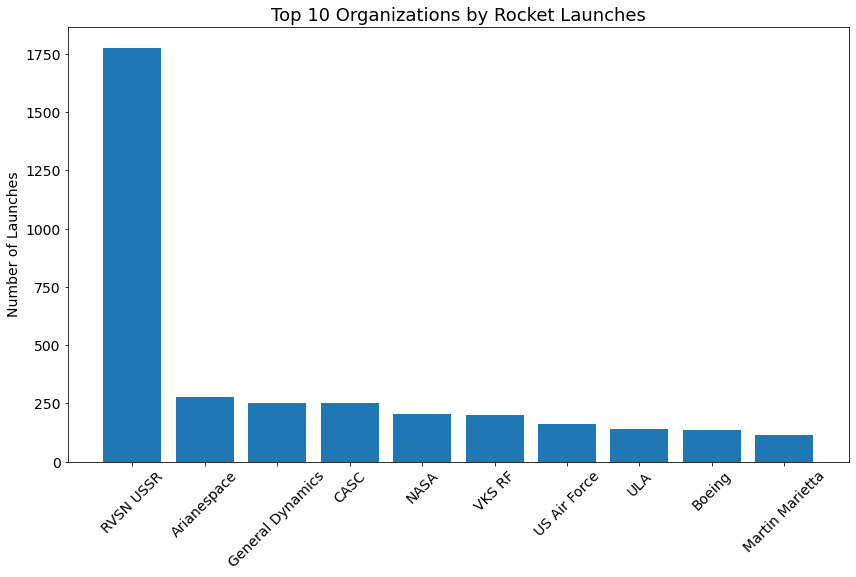

In [38]:
plt.figure(figsize=(14,8))
plt.title('Top 10 Organizations by Rocket Launches', fontsize=18)

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
# plt.xlabel('Organization', fontsize=14)
plt.ylabel('Number of Launches', fontsize=14)

plt.bar(df_orgs.index[0:10], df_orgs.values[0:10])

<BarContainer object of 10 artists>

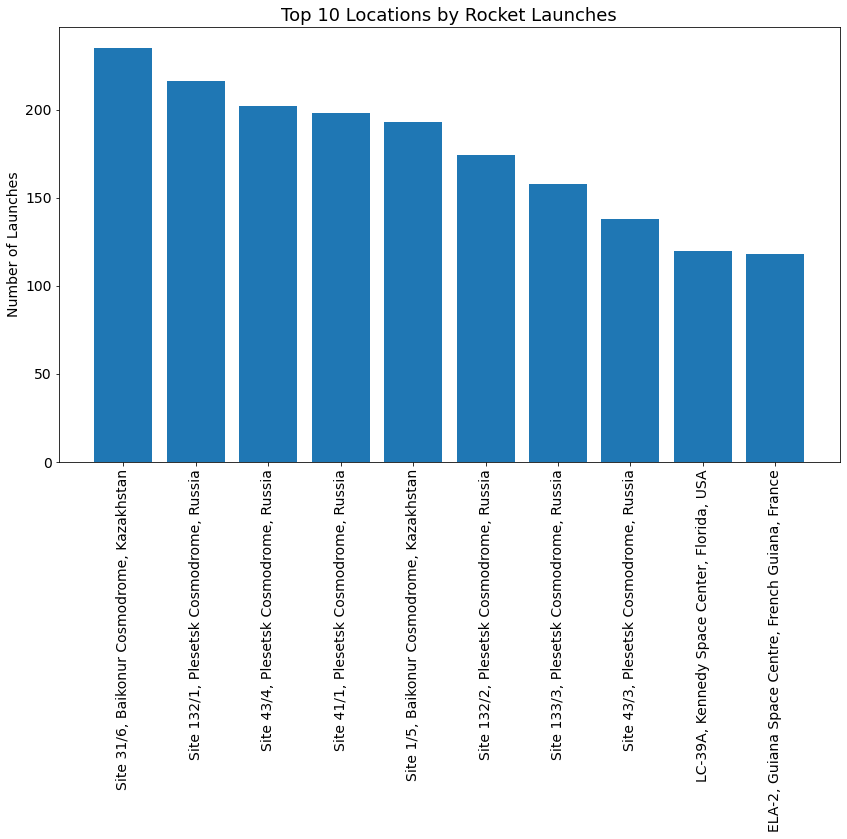

In [44]:
plt.figure(figsize=(14,8))
plt.title('Top 10 Locations by Rocket Launches', fontsize=18)

plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
# plt.xlabel('Locations', fontsize=14)
plt.ylabel('Number of Launches', fontsize=14)

plt.bar(df_locations.index[0:10], df_locations.values[0:10])

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

In [46]:
df_rockets = df.value_counts('Rocket_Status')
df_rockets

Rocket_Status
StatusRetired    3534
StatusActive      790
dtype: int64

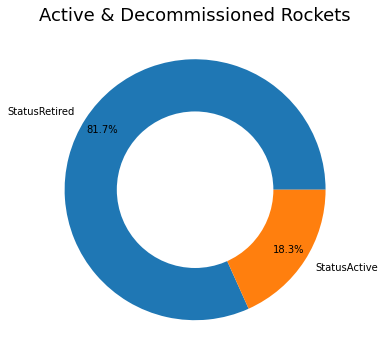

In [54]:
# Set figure size
plt.figure(figsize=(6,6))

# Pie Chart
plt.pie(df_rockets.values, labels=df_rockets.index, autopct='%1.1f%%', pctdistance=0.85)

# draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Format and display chart
plt.title('Active & Decommissioned Rockets', fontsize=18)
plt.show()

# Distribution of Mission Status

How many missions were successful?
How many missions failed?

In [57]:
df_success = df.value_counts('Mission_Status')
df_success

Mission_Status
Success              3879
Failure               339
Partial Failure       102
Prelaunch Failure       4
dtype: int64

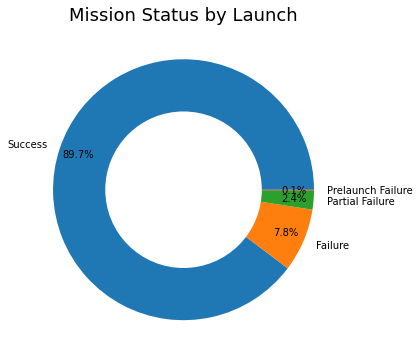

In [59]:
plt.figure(figsize=(6, 6))

# Pie Chart
plt.pie(df_success.values, labels=df_success.index, autopct='%1.1f%%', pctdistance=0.85)

# draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Format and display chart
plt.title('Mission Status by Launch', fontsize=18)
plt.show()

# How Expensive are the Launches? 

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values). 

In [66]:
# Missing Prices
df['Price'].isna().value_counts()

True     3360
False     964
Name: Price, dtype: int64

In [86]:
df[['Date', 'Price', 'Real_Price']].sort_values(by='Real_Price', ascending=False)

,Date,Price,Real_Price
2000,1987-05-15 17:30:00,"5,000.00","11,490.63"
1916,1988-11-15 03:00:00,"5,000.00","10,802.91"
3716,1967-11-09 12:00:00,"1,160.00","8,920.26"
3683,1968-04-04 12:00:00,"1,160.00","8,764.68"
3603,1968-12-21 12:51:00,"1,160.00","8,493.10"
...,...,...,...
4319,1958-02-05 07:33:00,NaN,NaN
4320,1958-02-01 03:48:00,NaN,NaN
4321,1957-12-06 16:44:00,NaN,NaN
4322,1957-11-03 02:30:00,NaN,NaN


Text(0.5, 0.98, 'Histograms of Nominal Prices (left) and Real Prices (Right) in millions of USD')

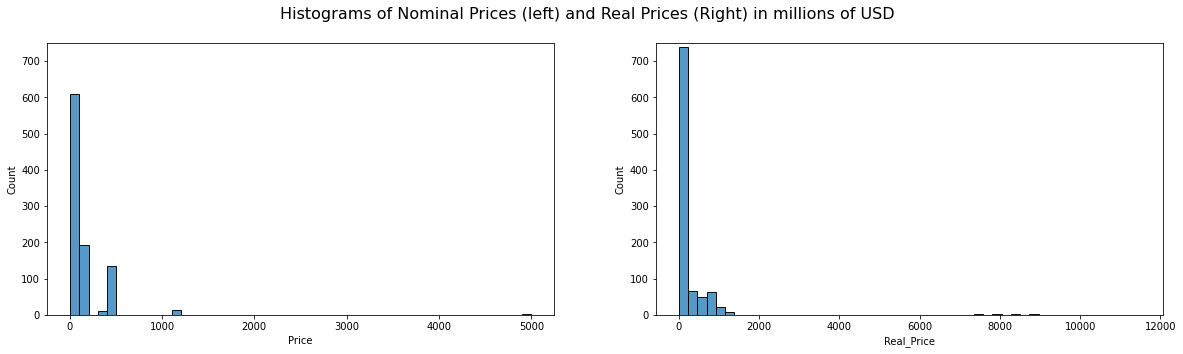

In [122]:
# Plot two histograms side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.histplot(data=df, x=df['Price'], bins=50, ax=ax1)
sns.histplot(data=df, x=df['Real_Price'], bins=50, ax=ax2)

# Assign the same y lim to each subplot
ax1.set_ylim([0, 750])
ax2.set_ylim([0, 750])

fig.suptitle('Histograms of Nominal Prices (left) and Real Prices (Right) in millions of USD', fontsize=16)

Text(0.5, 0.98, 'Histograms of Nominal Prices (left) and Real Prices (Right) in millions of USD (outliers removed)')

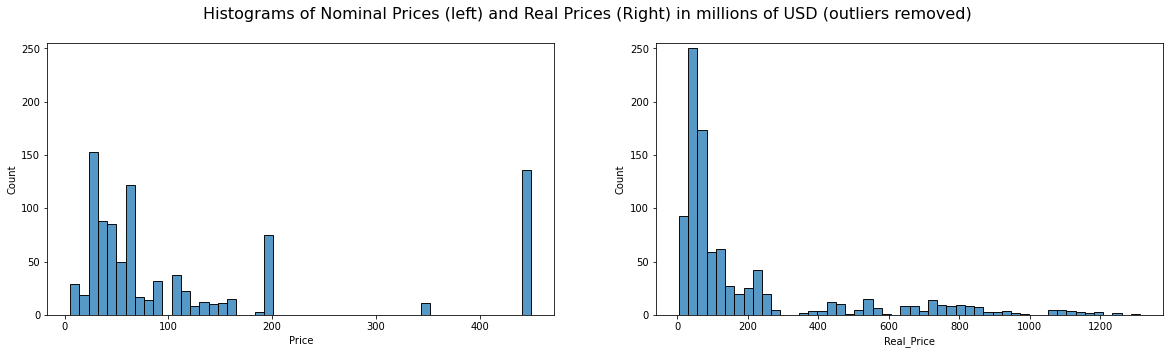

In [127]:
# Remove Outliers
df_without_outliers = df[df['Real_Price'] < 5000]

# Plot two histograms side-by-side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
sns.histplot(data=df_without_outliers, x=df_without_outliers['Price'], bins=50, ax=ax1)
sns.histplot(data=df_without_outliers, x=df_without_outliers['Real_Price'], bins=50, ax=ax2)

# Assign the same y lim to each subplot
ax1.set_ylim([0, 255])
ax2.set_ylim([0, 255])

fig.suptitle('Histograms of Nominal Prices (left) and Real Prices (Right) in millions of USD (outliers removed)', fontsize=16)

# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [189]:
# Define dictionary of places to rename
country_dict = {
    'Russia': 'Russian Federation',
    'Pacific Ocean': 'Russian Federation',
    'Barents Sea': 'Russian Federation',
    'Iran': 'Iran, Islamic Republic of',
    'Shahrud Missile Test Site': 'Iran, Islamic Republic of',
    'New Mexico': 'USA',
    'Yellow Sea': 'China',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Pacific Missile Range Facility': 'USA',
    'Gran Canaria': 'USA'
}

def where_in_the_world_is_carmen_sandiego(location, year):
    # Clean location
    last_part = location.split(',')[-1]
    cleaned_loc = last_part.strip()

    # Get ISO code from country name
    try:
        iso = countries.get(cleaned_loc)

    # If no result, run it through country dictionary first
    except KeyError:
        # Launches on the Kiritimati (Christmas) Island in the Pacific Ocean were conducted by the multinational org Sea Launch
        # In 2010 they switched from being plurality owned by the US to being majority owned by Russia
        if cleaned_loc == 'Pacific Ocean':
            if year <= 2010:
                official_name = 'USA'
            elif year > 2010:
                official_name = 'Russian Federation'
            iso = countries.get(official_name)

        else:
            official_name = country_dict[cleaned_loc]
            iso = countries.get(official_name)

    return iso.alpha3

# Add results as an ISO column to the dataframe
iso_list = []
for idx, row in df.iterrows():
    launch_year = row['Date'].year
    launch_location = df.iloc[idx]['Location']
    iso = where_in_the_world_is_carmen_sandiego(launch_location, launch_year)
    iso_list.append(iso)

df['ISO'] = iso_list

# Use a Choropleth Map to Show the Number of Failures by Country


In [203]:
# Map the number of launch failures by country
df_fails = df[df['Mission_Status'] == 'Failure'].value_counts('ISO')

fig = px.choropleth(df_fails,
                    locations=df_fails.index,
                    locationmode="ISO-3",
                    color=df_fails.values,
                    color_continuous_scale=px.colors.sequential.matter
                    )
fig.update_geos(projection_type="natural earth")
fig.show()

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status. 

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

# Analyse the Amount of Money Spent by Organisation per Launch

# Chart the Number of Launches per Year

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart. 

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

# How has the Launch Price varied Over Time? 

Create a line chart that shows the average price of rocket launches over time. 

# Chart the Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

Hint: Remember to include former Soviet Republics like Kazakhstan when analysing the total number of launches. 

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

## Chart the Total Number of Mission Failures Year on Year.

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches? 

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 